In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.device_count()

6

In [4]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [34]:
def imshow(img, title='', std=std, mean=mean,figsize=(16,16)):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = figsize)
    plt.imshow(img)
    plt.title(title)

In [6]:
class IFoodDataset(Dataset):
    def __init__(self, labels_csv, data_path, transforms):
        self.labels_df = pd.read_csv(labels_csv)
        self.data_path = root_path / data_path
        self.compose = transforms
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.data_path/self.labels_df.iloc[idx, 0]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.compose(image)
        return {'image':image,'label':self.labels_df.iloc[idx, 1]}

In [7]:
bs=128
root_path = Path.cwd() / 'ifood'
train_labels_csv = 'train_labels.csv'
train_data_path = 'train_set'
train_dataset = IFoodDataset(root_path/train_labels_csv, root_path/train_data_path, test_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False,num_workers=4)
val_labels_csv = 'val_labels.csv'
val_data_path = 'val_set'
val_dataset = IFoodDataset(root_path/val_labels_csv, root_path/val_data_path, test_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False,num_workers=4)

In [8]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
model = model.to(device)
model = nn.DataParallel(model).to(device)

In [9]:
model.module.load_state_dict(torch.load('saved_model.pt'))
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
class EmbeddingExtractor:
    def sniff_output(self,model, input, output):
        self.embeddings=output  
    def __init__(self,model):
        self.model = model
        self.model.eval()
        layer = self.model._modules.get('avgpool')
        self.handle = layer.register_forward_hook(self.sniff_output)
    def get_embeddings(self, input):
        with torch.no_grad():
            self.model(input.to(device))
        return self.embeddings.squeeze(-1).squeeze(-1)
extractor = EmbeddingExtractor(model.module)

In [11]:
#calculate all embeddings for trainset
all_emb=torch.tensor([])
for i,batch in enumerate(tqdm(train_dataloader)):
    emb = extractor.get_embeddings(batch['image'].to(device)).detach().cpu()
    all_emb=torch.cat([all_emb,emb],dim=0)

## Get Colsest Images

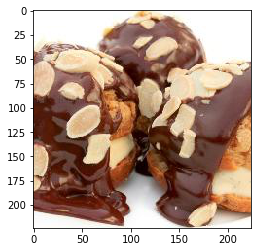

In [39]:
target_id = 4521
imshow(train_dataset[target_id]['image'],figsize=(4,4))

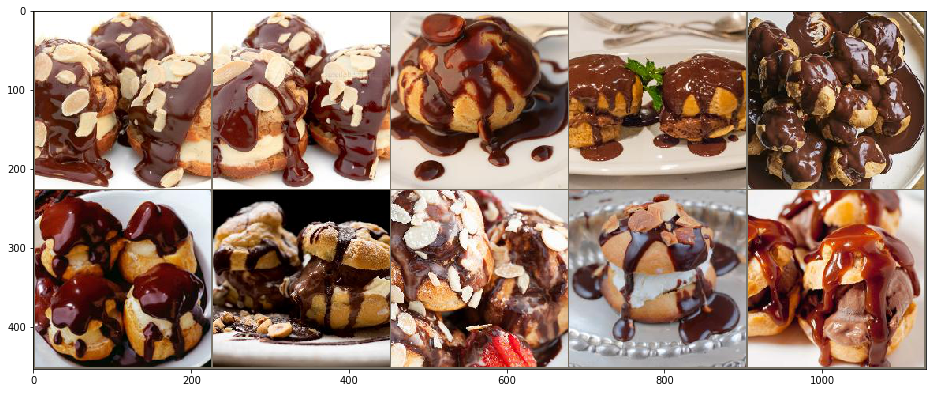

In [38]:
target_emb = extractor.get_embeddings(train_dataset[target_id]['image'].unsqueeze(0)).squeeze(0)
#euclidean distance to all other embeddings:
distances = (torch.pow(target_emb.cpu()-all_emb,2)).sum(dim=1).sqrt()
top_results = distances.argsort(descending=False)[:10]
top_images = torch.stack([train_dataset[i.item()]['image'] for i in top_results])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

## Try to figure out what featurs were learned

Each embeddings has 512 featurs. These features were learned while training and not picked by us but we can chose a feature and show the images that have the highes value for it. This way we can maybe try to guess what each feature is representing.

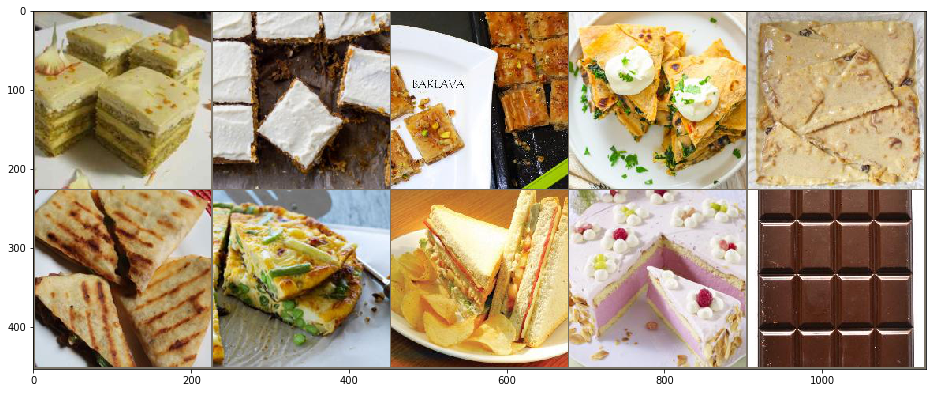

In [41]:
feature_index = 22
top_ten = sorted(range(len(all_emb)), key=lambda k: all_emb[k][feature_index].item(),reverse=True)[:10]
top_images = torch.stack([train_dataset[i]['image'] for i in top_ten])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

Nice! Feature 22 probably means "image contains stacked layers of something". Remember these images dont have to look alike, just share a single common trait.  
Lest try some more:

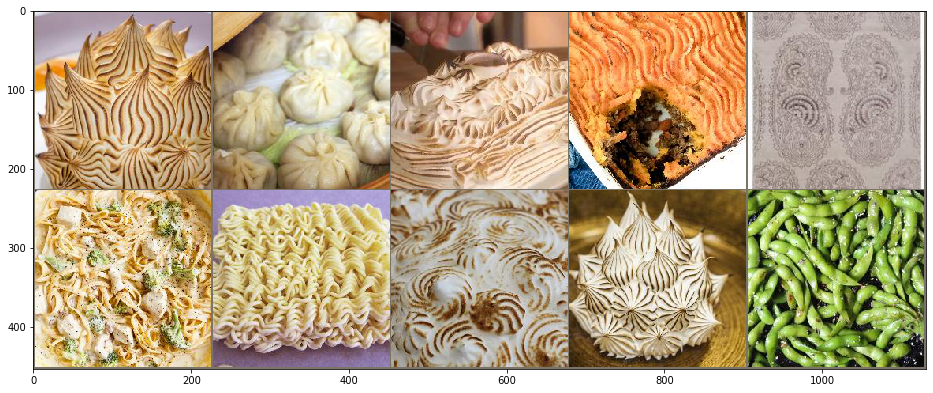

In [42]:
feature_index = 10
top_ten = sorted(range(len(all_emb)), key=lambda k: all_emb[k][feature_index].item(),reverse=True)[:10]
top_images = torch.stack([train_dataset[i]['image'] for i in top_ten])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

Feature 10 means: "image contains lots of streight lines that connect to single points"

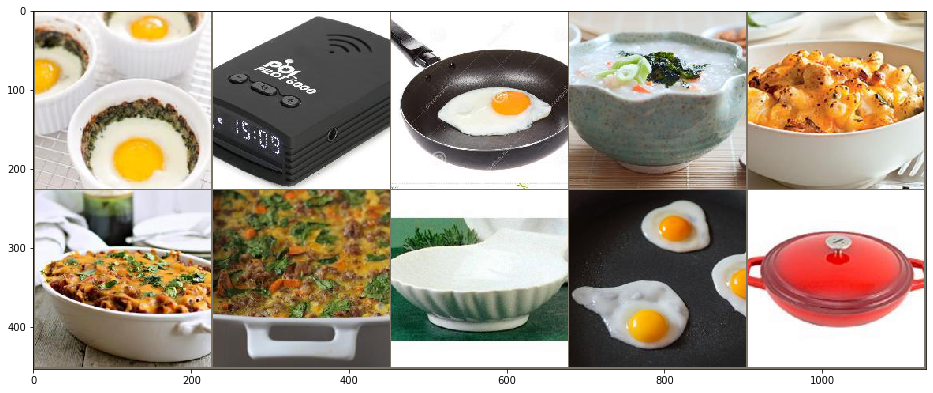

In [40]:
feature_index = 333
top_ten = sorted(range(len(all_emb)), key=lambda k: all_emb[k][feature_index].item(),reverse=True)[:10]
top_images = torch.stack([train_dataset[i]['image'] for i in top_ten])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

Feature 33 means: "image contains something white and round with something yellowish inside"

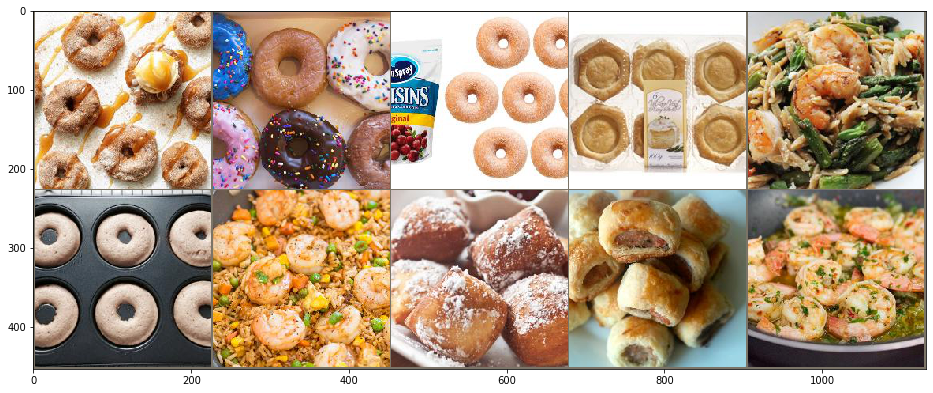

In [46]:
feature_index = 101
top_ten = sorted(range(len(all_emb)), key=lambda k: all_emb[k][feature_index].item(),reverse=True)[:10]
top_images = torch.stack([train_dataset[i]['image'] for i in top_ten])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

Feature 101 means: "image contains something round and brownish"